In [1]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Organize and Convert Aggregated df to csv

We first need to concatonate all the data that we want to look at into one singular .csv file. We can use the ```Conatonate_Data_to_One.ipynb``` to do that

In [2]:
# Read the csv file
df = pd.read_csv('data/PGA_STAT_2024_ALL_DATA.csv')

# Soer df by column name
df.sort_index(axis = 1, inplace=True)

# Convert sorted df into a new csv file
df.to_csv('data/aggregated_df_ordered.csv', index = False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Columns: 113 entries, 3Putts_AVG to Total_Putts_AVG
dtypes: float64(103), int64(1), object(9)
memory usage: 157.3+ KB


## Cleaning the Dataframe

### Rename the columns if needed

You can rename each column to be easier to read using the code below OR you can manually change the column names.

In [4]:
# Change the names of columns to make it easier to read
df = df.rename(columns = {
    'AVG(1)': 'AVG_SG_PUTTING', 
    'AVG(10)': 'AVG_DISTANCE',
    'AVG(12)': 'AVG_SG',
    'AVG(13)': 'AVG_STROKE',
    'AVG(14)': 'AVG_PUTT_TOTAL',
    'AVG(15)': 'AVG_PUTT',
    'AVG(16)': 'AVG_PUTT_ROUND',
    'AVG(2)': 'REMOVE',
    'AVG(3)': 'AVG_SG_ARG',
    'AVG(6)': 'AVG_SG_APP',
    'AVG(8)': 'REMOVE2',
    'AVG(9)': 'AVG_SG_DRIVING',
    'AVG(0)': 'AVG_STROKES_ADJUSTED',
    })

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Columns: 113 entries, 3Putts_AVG to Total_Putts_AVG
dtypes: float64(103), int64(1), object(9)
memory usage: 157.3+ KB


### Drop Uneeded Columns

In [5]:
# Make a list of column names that we want to remove
columns_to_drop = ['REMOVE10a','REMOVE10b','REMOVE10c','REMOVE10d',
                  'REMOVE11a','REMOVE11b','REMOVE11c','REMOVE11d',
                  'REMOVE12a','REMOVE12b','REMOVE12c','REMOVE12d','REMOVE12e',
                  'REMOVE13a','REMOVE13b','REMOVE13c','REMOVE13d','REMOVE13e',
                  'REMOVE14a','REMOVE14b','REMOVE14c','REMOVE14d',
                  'REMOVE15a','REMOVE15b','REMOVE15c','REMOVE15d',
                  'REMOVE16a','REMOVE16b','REMOVE16c','REMOVE16d',
                  'REMOVE17a','REMOVE17b','REMOVE17c','REMOVE17d',
                  'REMOVE18a','REMOVE18b','REMOVE18c','REMOVE18d',
                  'REMOVE19a','REMOVE19b','REMOVE19c','REMOVE19d',
                  'REMOVE1a','REMOVE1b','REMOVE1c','REMOVE1d',
                  'REMOVE20a','REMOVE20b','REMOVE20c','REMOVE20d',
                  'REMOVE21a','REMOVE21b','REMOVE21c','REMOVE21d','REMOVE21e','REMOVE21f',
                  'REMOVE2a','REMOVE2b','REMOVE2c','REMOVE2d',
                  'REMOVE3a','REMOVE3b','REMOVE3c','REMOVE3d',
                  'REMOVE4a','REMOVE4b','REMOVE4c','REMOVE4d',
                  'REMOVE5a','REMOVE5b','REMOVE5c','REMOVE5d',
                  'REMOVE6a','REMOVE6b','REMOVE6c','REMOVE6d',
                  'REMOVE7a','REMOVE7b','REMOVE7c','REMOVE7d',
                  'REMOVE8a','REMOVE8b','REMOVE8c','REMOVE8d',
                  'REMOVE9a','REMOVE9b','REMOVE9c','REMOVE9d',#temp
                  'Fairway%','GIR%','GIR_off_Fairway%',
                  'GIR_on_Fairway%','PLAYER','Putting_Birdie_Conversions',
                  'Scrambling%','Scrambling_Rough%','Scrambling_Sand%',
                  ]

# Drop columns
df.drop(columns = columns_to_drop, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   3Putts_AVG           178 non-null    float64
 1   Driver_Distance_AVG  178 non-null    float64
 2   GIR_RELATIVE/PAR     178 non-null    float64
 3   PLAYER_ID            178 non-null    int64  
 4   Par3_AVG             178 non-null    float64
 5   Par4_AVG             178 non-null    float64
 6   Par5_AVG             178 non-null    float64
 7   Putting_AVG          178 non-null    float64
 8   Putts_Overall_AVG    178 non-null    float64
 9   SG_APP_AVG           178 non-null    float64
 10  SG_ARG_AVG           178 non-null    float64
 11  SG_DRIVE_AVG         178 non-null    float64
 12  SG_PUTTING_AVG       178 non-null    float64
 13  SG_TOTAL_AVG         178 non-null    float64
 14  Strokes_Adj_AVG      178 non-null    float64
 15  Total_Putts_AVG      178 non-null    flo

### Managing Datatypes

In order to use Machine Learning ALgorithms, the dataframe should be the same datatype. If there are objects or Strings, we need to convert them using a ```label encoder``` or remove them completely

In [6]:
# Function to clean all strings and columns
def remove_percent_sign(df):
    for x in df.columns:
        if df[x].dtype == 'object':
            if df[x].str.contains('%').any():
                df[x] = df[x].str.replace('%','',regex = False)
    return df

## Machine Learning Training

### Performing a Train_Test_Split

In [7]:
# Initialize features and targets
features = df[['SG_APP_AVG', 'SG_ARG_AVG','SG_DRIVE_AVG','SG_PUTTING_AVG']]
target = df[['Strokes_Adj_AVG']]

# Initialize Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)


### Initialize Machine Learning Models

In [8]:
# Initilize different bacic machine learning models
model_linear = LinearRegression()
model_rf = RandomForestRegressor()
model_svr = SVR()
model_knn = KNeighborsRegressor(n_neighbors = 2)
model_gb = GradientBoostingRegressor() 
model_dt = DecisionTreeRegressor()

# Train the models
model_linear.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_svr.fit(X_train, y_train)
model_knn.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
model_dt.fit(X_train, y_train)

c:\Users\Ivan\Documents\CMA\ML Sports Analytics\Sports-Analytics-Machine-Learning\venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Ivan\Documents\CMA\ML Sports Analytics\Sports-Analytics-Machine-Learning\venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Ivan\Documents\CMA\ML Sports Analytics\Sports-Analytics-Machine-Learning\venv\lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this st

DecisionTreeRegressor()

### Make Predictions and Evaluate Performance

The Mean Squared Error(MSE) measures the average squared difference between the predicted values and the actual values. It quantifies how close the predictions are to the actual outcome.
$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

The $R^2$ represents the proportion of the variance in the target variable. Mesaures the 'goodness of fit' of the model. 1 Indicates that the model explains 100% of the variance in the target variable. 0 indicates that the models explains none of the variance and the predictions are **as good as the mean of the target variable**. An $R^2$ < 0 indicates that the model performs worse than a simple mean-bsaed prediction.
$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

### Making Predictions for Model Evaluation

In [9]:
# Import methods created in the utils folder
from utils.metrics import evaluate_model

# Make predictions
y_pred_linear = model_linear.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
y_pred_svr = model_svr.predict(X_test)
y_pred_knn = model_knn.predict(X_test)
y_pred_gb = model_gb.predict(X_test)
y_pred_dt = model_dt.predict(X_test)

### Evaluating Performance of ML Models Created

In [10]:
# Evaluate performance
mse_linear, r2_linear = evaluate_model(y_test, y_pred_linear)
mse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)
mse_svr, r2_svr = evaluate_model(y_test, y_pred_svr)
mse_knn, r2_knn = evaluate_model(y_test, y_pred_knn)
mse_gb, r2_gb = evaluate_model(y_test, y_pred_gb)
mse_dt, r2_dt = evaluate_model(y_test, y_pred_dt)

# Print the results
print("Linear Regression Performance:")
print(f"Mean Squared Error: {mse_linear}")
print(f"R^2 Score: {r2_linear}")

print("\nRandom Forest Regressor Performance:")
print(f"Mean Squared Error: {mse_rf}")
print(f"R^2 Score: {r2_rf}")

print("\nSupport Vector Regressor Performance:")    
print(f"Mean Squared Error: {mse_svr}")
print(f"R^2 Score: {r2_svr}")

print("\nK-Nearest Neighbors Regressor Performance:")
print(f"Mean Squared Error: {mse_knn}")
print(f"R^2 Score: {r2_knn}")

print("\nGradient Boosting Regressor Performance:")
print(f"Mean Squared Error: {mse_gb}")
print(f"R^2 Score: {r2_gb}")

print("\nDecision Tree Regressor Performance:")
print(f"Mean Squared Error: {mse_dt}")
print(f"R^2 Score: {r2_dt}")

Linear Regression Performance:
Mean Squared Error: 0.03257265868803971
R^2 Score: 0.9481663515335483

Random Forest Regressor Performance:
Mean Squared Error: 0.1047940162722173
R^2 Score: 0.8332387830890746

Support Vector Regressor Performance:
Mean Squared Error: 0.13590850605510496
R^2 Score: 0.7837255535714794

K-Nearest Neighbors Regressor Performance:
Mean Squared Error: 0.1152295833333344
R^2 Score: 0.8166324163882611

Gradient Boosting Regressor Performance:
Mean Squared Error: 0.08392163643046638
R^2 Score: 0.8664534988338728

Decision Tree Regressor Performance:
Mean Squared Error: 0.2185406944444427
R^2 Score: 0.6522309818201333


### Making Predictions

Predictions need to be based on the number of features. This means that if you have 5 features that were used to train the model, you need 5 inputs to make a prediction

In [11]:
# Example of individual user input

user_input1 = 1 # SG_APP_AVG
user_input2 = 2.3 # SG_ARG_AVG
user_input3 = 0.5 # SG_DRIVE_AVG 
user_input4 = 1.6 # SG_PUTTING_AVG  

# Combine indiividual user input to same format as what was trained
user_input = [[user_input1,user_input2,user_input3,user_input4]]

# Make predictions with each model
y_pred_linear_new = model_linear.predict(user_input)
y_pred_rf_new = model_rf.predict(user_input)
y_pred_svr_new = model_svr.predict(user_input)
y_pred_knn_new = model_knn.predict(user_input)
y_pred_gb_new = model_gb.predict(user_input)
y_pred_dt_new = model_dt.predict(user_input)

# Output predictions
print("Prediction using Linear Regression:")
print(y_pred_linear_new)

print("\nPrediction using Random Forest Regressor:")
print(y_pred_rf_new)

print("\nPrediction using Support Vector Regressor:")
print(y_pred_svr_new)

print("\nPrediction using K-Nearest Neighbors Regressor:")
print(y_pred_knn_new)

print("\nPrediction using Gradient Boosting Regressor:")
print(y_pred_gb_new)

print("\nPrediction using Decision Tree Regressor:")
print(y_pred_dt_new)

Prediction using Linear Regression:
[[66.15239656]]

Prediction using Random Forest Regressor:
[69.81587]

Prediction using Support Vector Regressor:
[71.19214095]

Prediction using K-Nearest Neighbors Regressor:
[[70.1125]]

Prediction using Gradient Boosting Regressor:
[69.51731179]

Prediction using Decision Tree Regressor:
[70.317]


c:\Users\Ivan\Documents\CMA\ML Sports Analytics\Sports-Analytics-Machine-Learning\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Ivan\Documents\CMA\ML Sports Analytics\Sports-Analytics-Machine-Learning\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Ivan\Documents\CMA\ML Sports Analytics\Sports-Analytics-Machine-Learning\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\Ivan\Documents\CMA\ML Sports Analytics\Sports-Analytics-Machine-Learning\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\Users\Ivan\Documents\CMA\M

## Graphs

### Model Predictions vs Actual Values

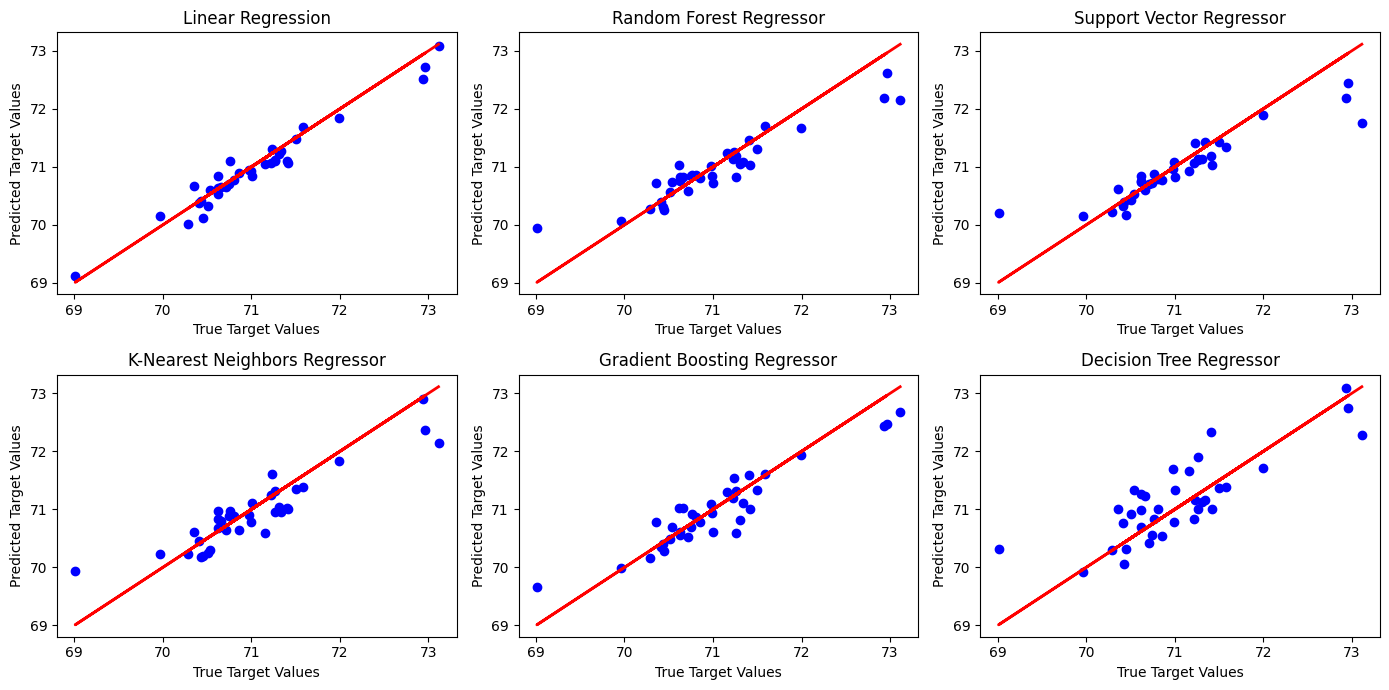

In [12]:
# Plot predictions vs. actual values
plt.figure(figsize=(14, 7))

# Linear Regression
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred_linear, color='blue')
plt.plot(y_test, y_test, color='red', linewidth=2)
plt.xlabel('True Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Linear Regression')

# Random Forest Regressor
plt.subplot(2, 3, 2)
plt.scatter(y_test, y_pred_rf, color='blue')
plt.plot(y_test, y_test, color='red', linewidth=2)
plt.xlabel('True Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Random Forest Regressor')

# Support Vector Regressor
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_pred_svr, color='blue')
plt.plot(y_test, y_test, color='red', linewidth=2)
plt.xlabel('True Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Support Vector Regressor')

# K-Nearest Neighbors Regressor
plt.subplot(2, 3, 4)
plt.scatter(y_test, y_pred_knn, color='blue')
plt.plot(y_test, y_test, color='red', linewidth=2)
plt.xlabel('True Target Values')
plt.ylabel('Predicted Target Values')
plt.title('K-Nearest Neighbors Regressor')

# Gradient Boosting Regressor
plt.subplot(2, 3, 5)
plt.scatter(y_test, y_pred_gb, color='blue')
plt.plot(y_test, y_test, color='red', linewidth=2)
plt.xlabel('True Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Gradient Boosting Regressor')

# Decision Tree Regressor
plt.subplot(2, 3, 6)
plt.scatter(y_test, y_pred_dt, color='blue')
plt.plot(y_test, y_test, color='red', linewidth=2)
plt.xlabel('True Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Decision Tree Regressor')

plt.tight_layout()
plt.show()


### Learning Curves of Models

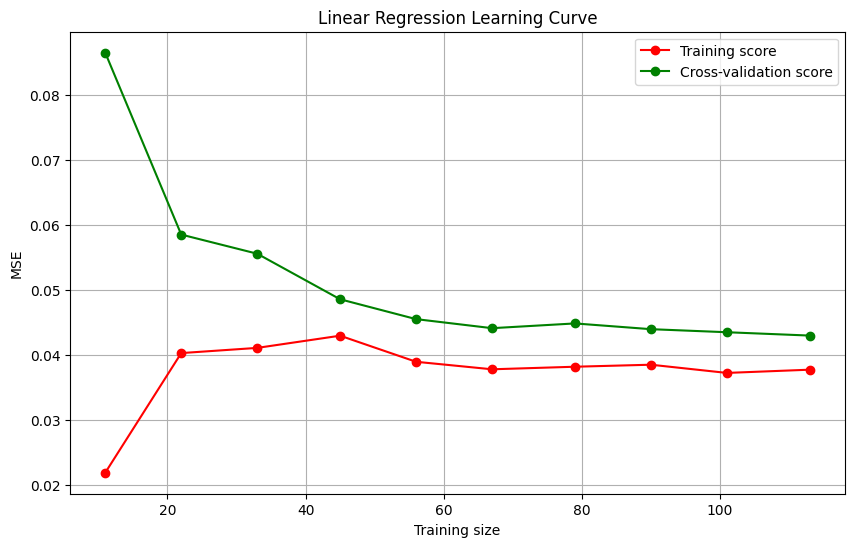

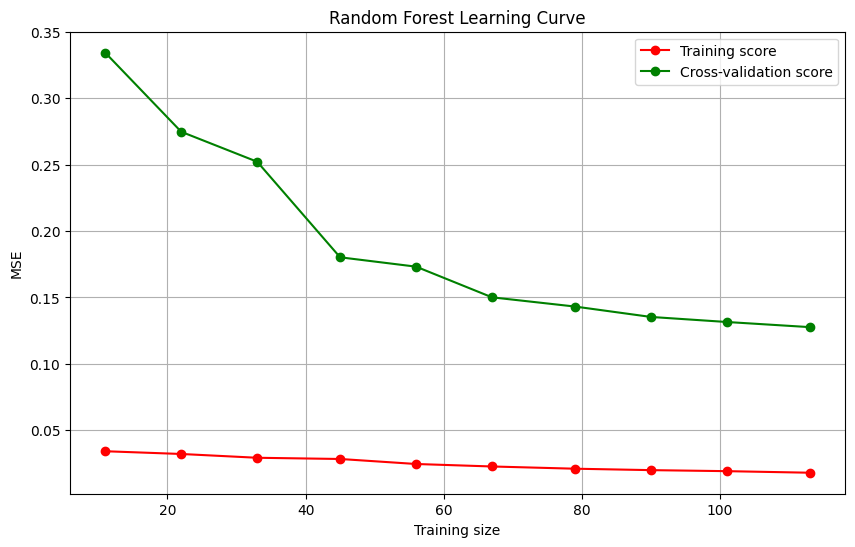

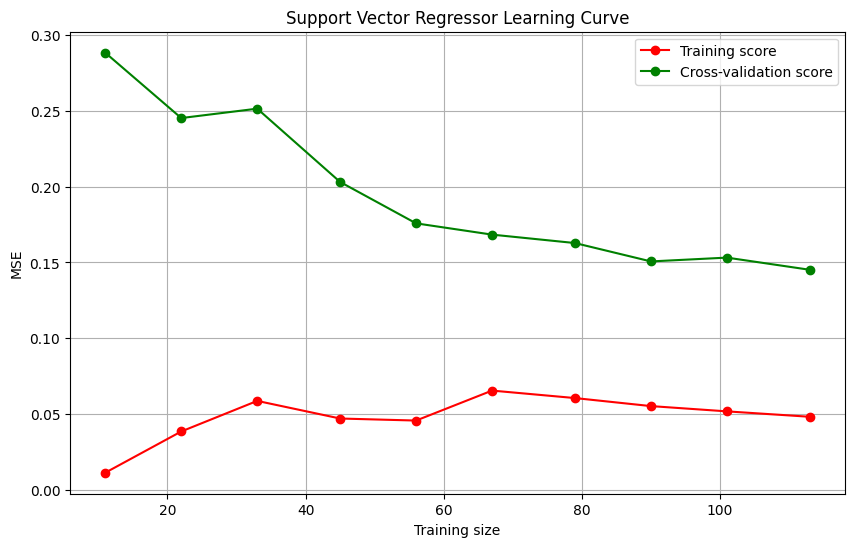

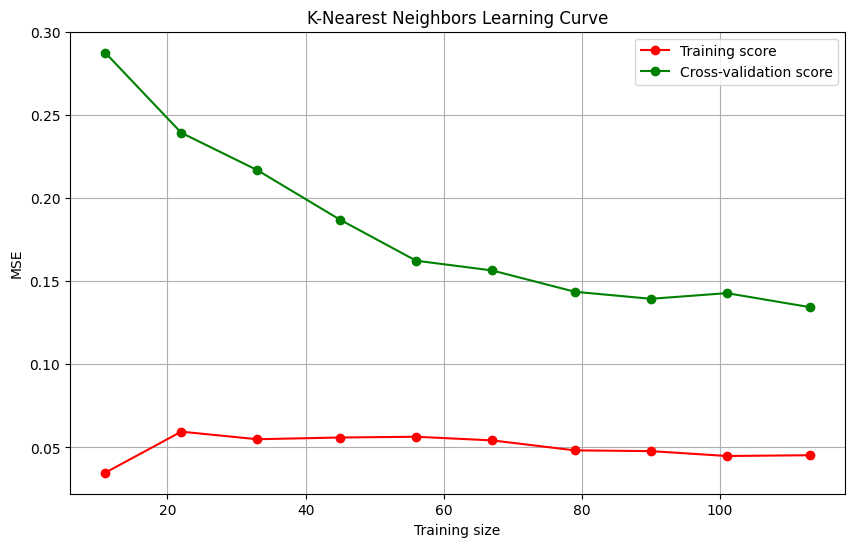

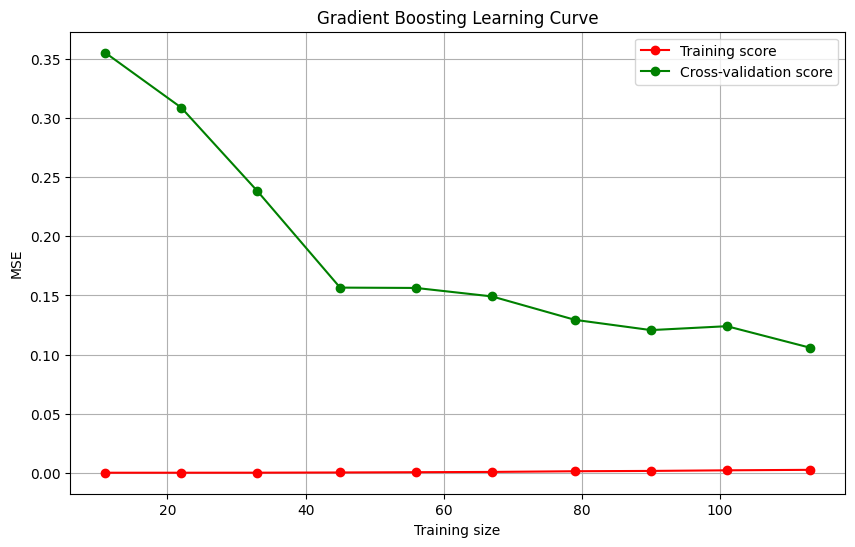

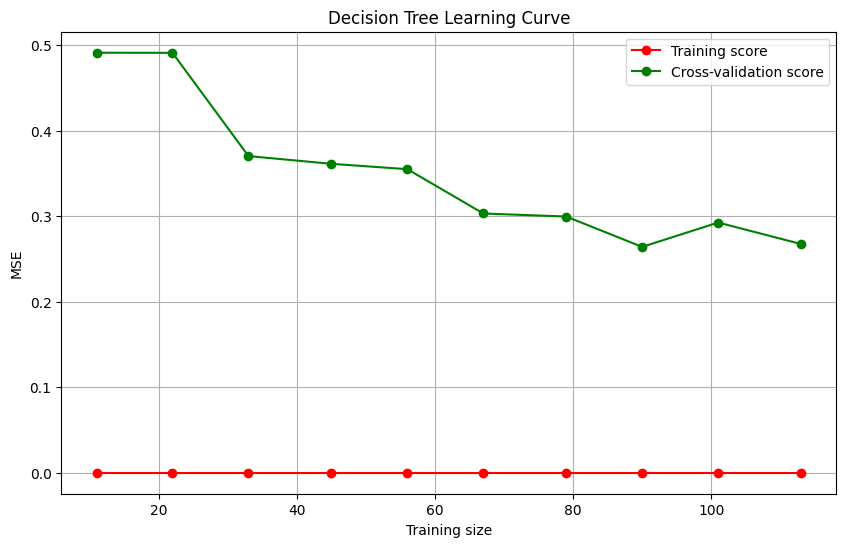

In [13]:
from utils.plot_learning_curve import plot_learning_curve

# Plot learning curves for each model
plot_learning_curve(model_linear, X_train, y_train, title="Linear Regression Learning Curve")
plot_learning_curve(model_rf, X_train, y_train, title="Random Forest Learning Curve")
plot_learning_curve(model_svr, X_train, y_train, title="Support Vector Regressor Learning Curve")
plot_learning_curve(model_knn, X_train, y_train, title="K-Nearest Neighbors Learning Curve")
plot_learning_curve(model_gb, X_train, y_train, title="Gradient Boosting Learning Curve")
plot_learning_curve(model_dt, X_train, y_train, title="Decision Tree Learning Curve")

### Pair Plots for All Columns

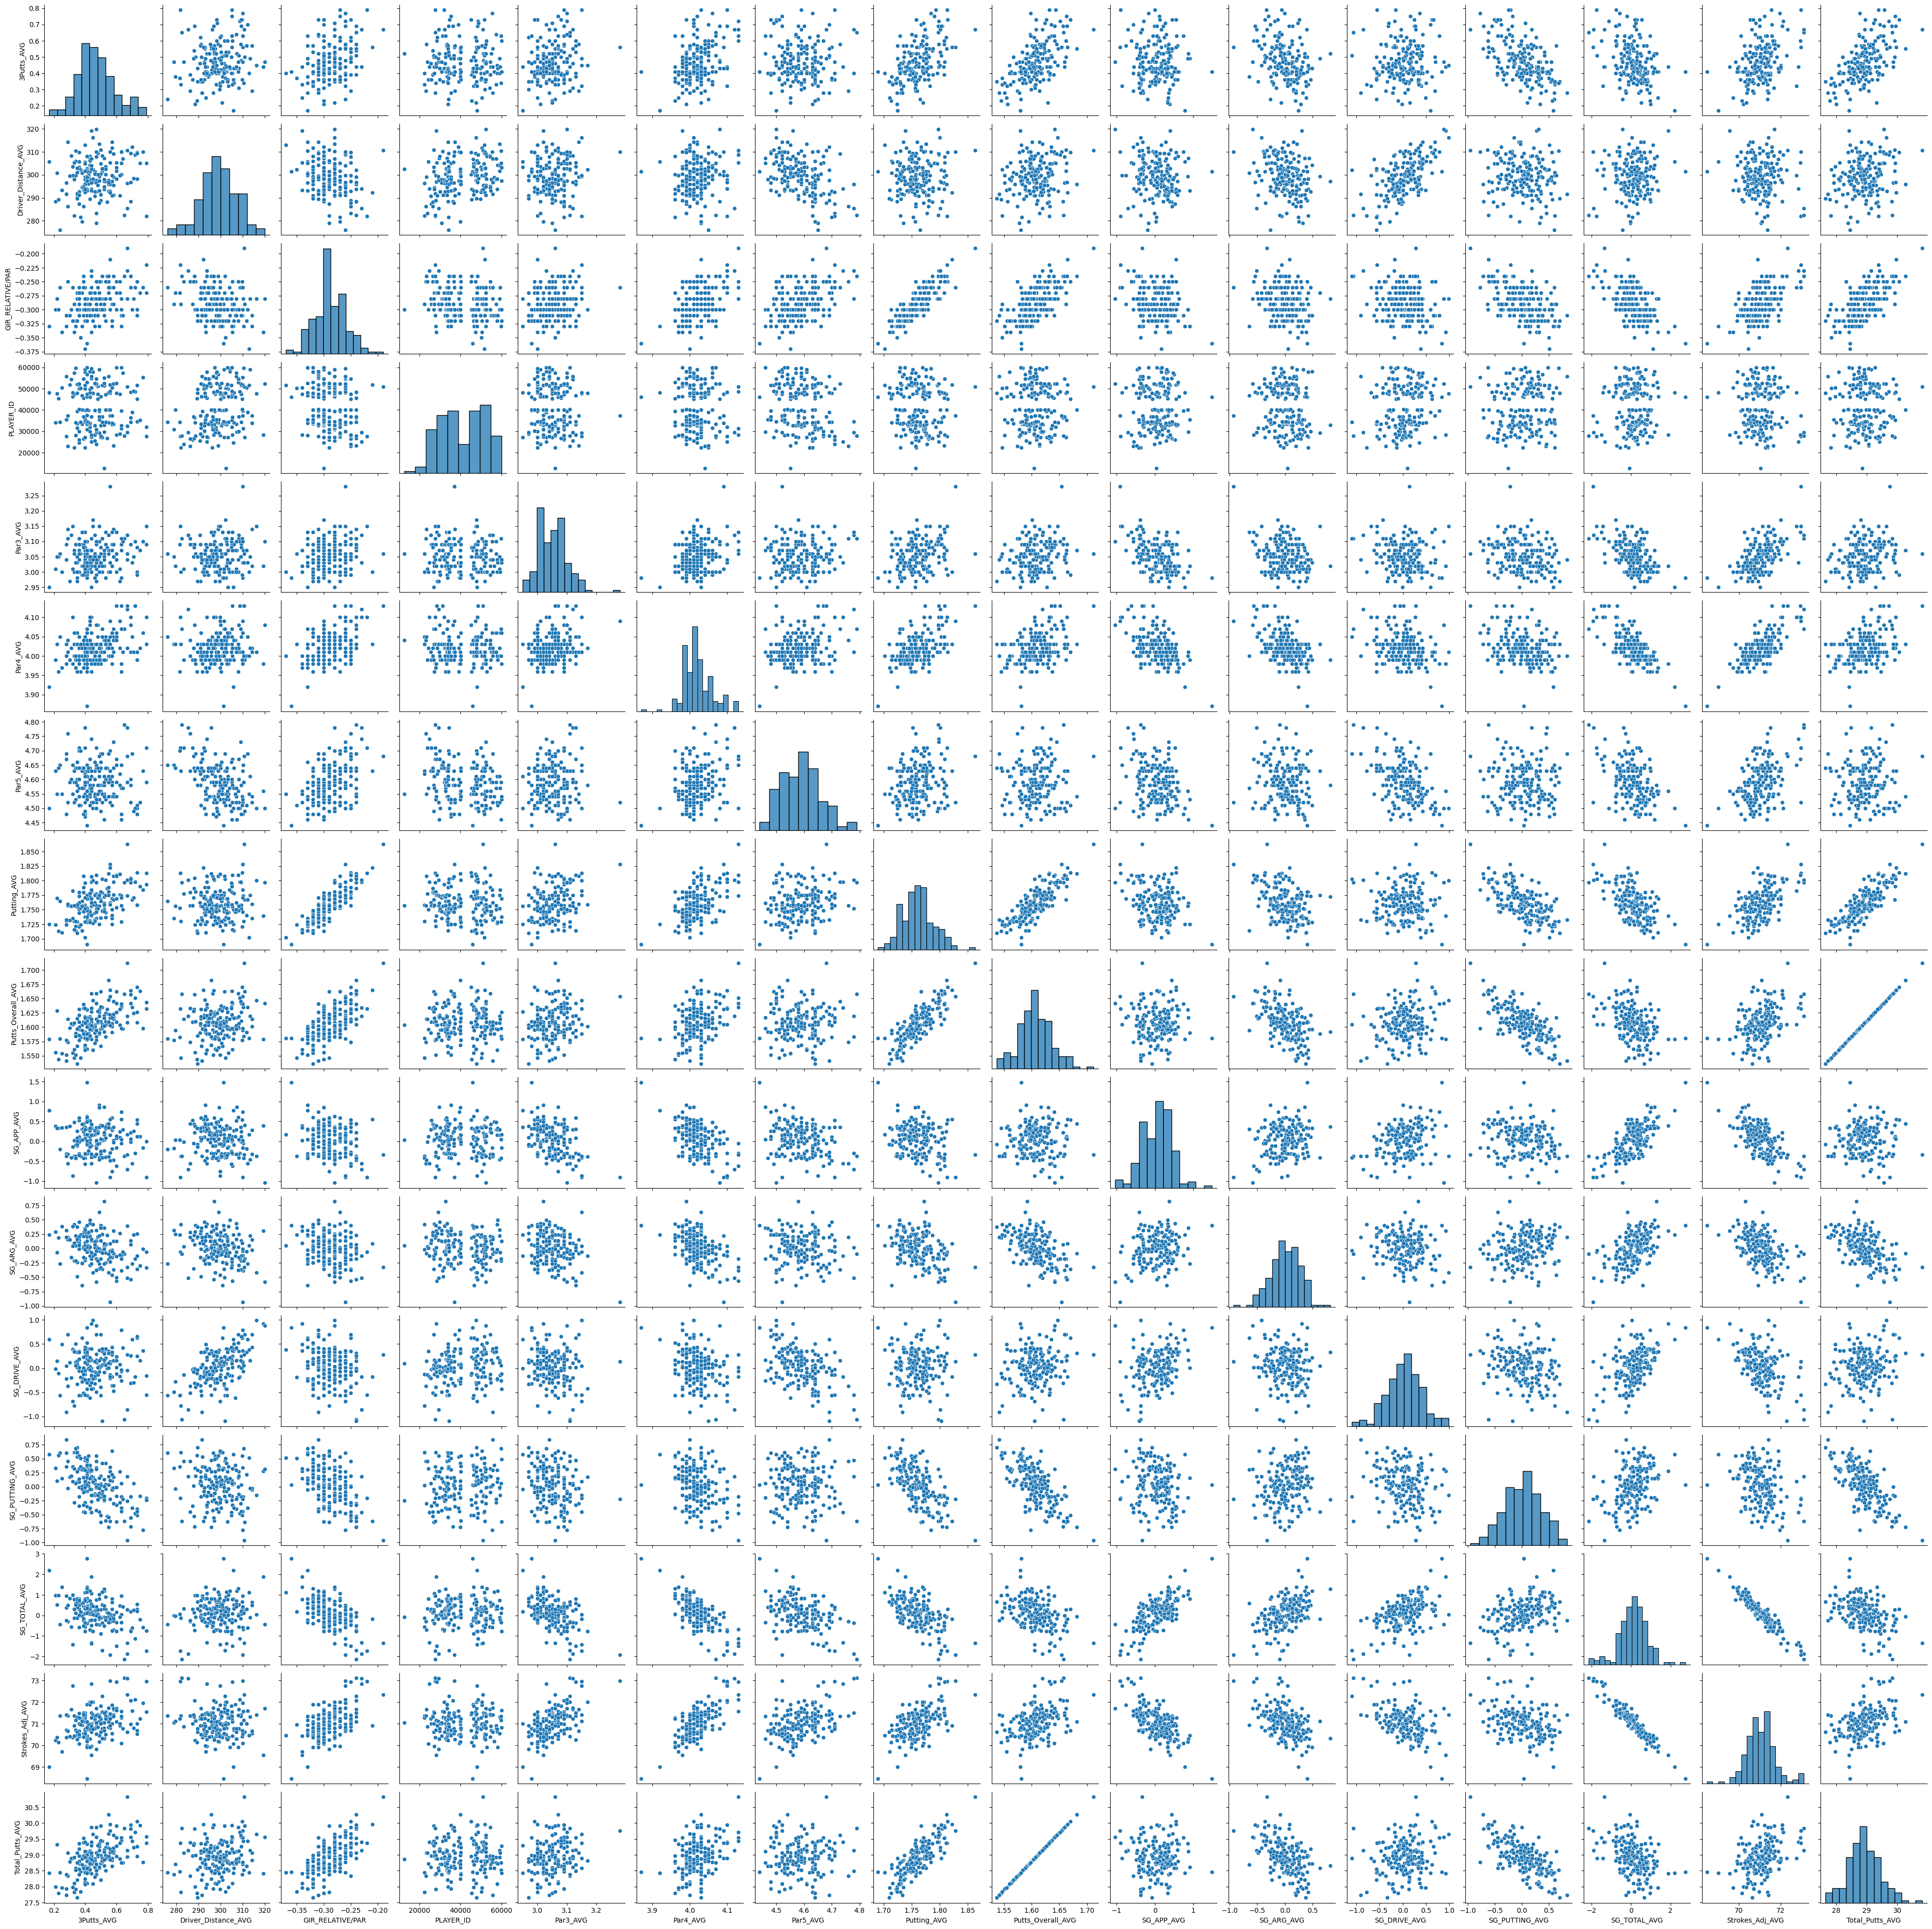

In [14]:
# Use seaborn to show the relationhsip of every column and visulize it
sns.pairplot(df)
plt.show()

### Correlation Matrix

Helps identify **Linear Relationships** between variables

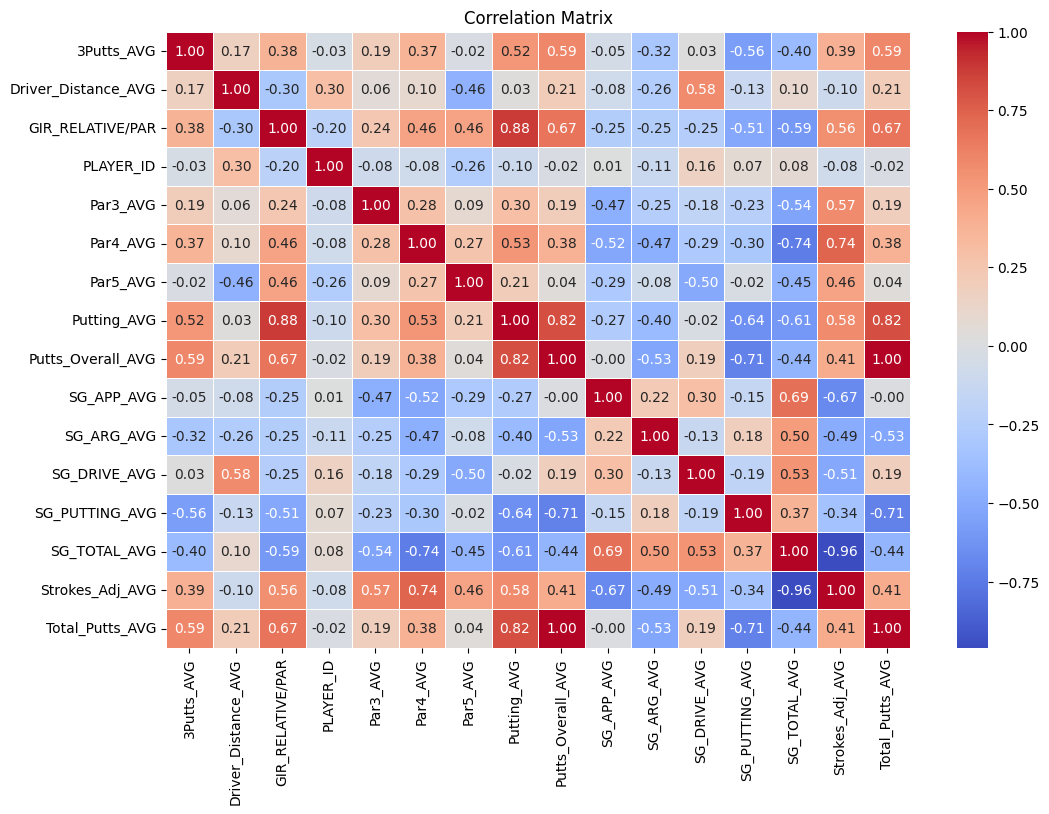

In [15]:
# Need to first make sure that all datatypes of the dataframe are numerical
# You can do this by only chossing the numerical columns OR using a labelencoder and convert the object datatypes to numerical

# Select only the numeric columns
numeric_df = df.select_dtypes(include=[float, int])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Deep Learning Models

### Initialize new Target and Features for Deep Learning

In [16]:
# Initialize features and targets
features = df[['SG_APP_AVG', 'SG_ARG_AVG','SG_DRIVE_AVG','SG_PUTTING_AVG']]
targets = df[['Strokes_Adj_AVG']]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Standardize features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Standardize targets (important for deep learning)
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

### Build the Deep Learning Model - Sequential Model

In [17]:
# Initialize the model
model = Sequential()

# Add layers
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer (2 outputs for longitude and latitude)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

### Train the Deep Learning Model

In [18]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.2, verbose=1)

# Save the model
model.save('../Sports-Analytics-Machine-Learning/models/NN_SGAPP_Input')

Epoch 1/100

15/15 [==============================] - 1s 13ms/step - loss: 0.9758 - val_loss: 0.5545
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.6066 - val_loss: 0.3124
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.2758 - val_loss: 0.1321
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1244 - val_loss: 0.1112
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1176 - val_loss: 0.0997
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0939 - val_loss: 0.1314
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0872 - val_loss: 0.1162
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0798 - val_loss: 0.1262
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0778 - val_loss: 0.1120
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0734 - val_loss: 0.1272
Epoch 1

INFO:tensorflow:Assets written to: ../Sports-Analytics-Machine-Learning/models/NN_SGAPP_Input\assets


### Evauluate the Performance of the Model

In [19]:
# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Loss on test data: {loss:.4f}')

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions and true values
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

# Calculate metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')


2/2 [==============================] - 0s 3ms/step - loss: 0.1058
Loss on test data: 0.1058
2/2 [==============================] - 0s 4ms/step
Mean Absolute Error: 0.17
Mean Squared Error: 0.05
Root Mean Squared Error: 0.22
R-squared: 0.92


# Plot How the Neural Network was Trained

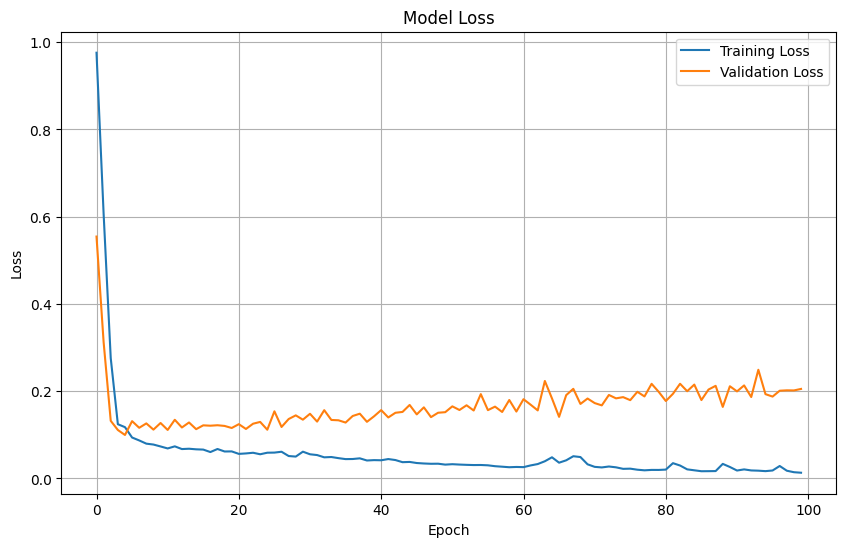

In [20]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [21]:
# Remove percent
df = pd.read_csv('../Sports-Analytics-Machine-Learning/data/PGA_STAT_2024_ALL_DATA.csv')
df.info()

# list of percent columns
list = ['Fairway%']

for col in list:
    df[col] = df[col].str.rstrip('%').astype('float') / 100

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Columns: 113 entries, PLAYER_ID to REMOVE21f
dtypes: float64(103), int64(1), object(9)
memory usage: 157.3+ KB


,PLAYER_ID,REMOVE1a,REMOVE1b,PLAYER,3Putts_AVG,REMOVE1c,REMOVE1d,REMOVE2a,REMOVE2b,Fairway%,...,SG_PUTTING_AVG,REMOVE20c,REMOVE20d,REMOVE21a,REMOVE21b,SG_TOTAL_AVG,REMOVE21c,REMOVE21d,REMOVE21e,REMOVE21f
0,12716,52.0,2.0,Charley Hoffman,0.52,23.0,44.0,150.0,-1.0,0.5526,...,-0.252,-9.815,39.0,113.0,-1.0,-0.069,-2.682,7.132,-9.815,39.0
1,22371,161.0,-2.0,Aaron Baddeley,0.33,16.0,48.0,139.0,0.0,0.5697,...,0.610,26.220,43.0,121.0,-1.0,-0.127,-5.476,-31.698,26.220,43.0
2,22405,124.0,-22.0,Justin Rose,0.40,22.0,55.0,57.0,9.0,0.6282,...,0.020,0.949,47.0,152.0,-1.0,-0.557,-26.195,-27.144,0.949,47.0
3,23108,168.0,-1.0,Matt Kuchar,0.29,13.0,45.0,38.0,0.0,0.6470,...,0.452,19.884,44.0,135.0,-1.0,-0.284,-12.500,-32.386,19.884,44.0
4,23320,29.0,4.0,Ryan Palmer,0.58,21.0,36.0,34.0,-2.0,0.6504,...,-0.304,-9.727,32.0,159.0,-1.0,-0.712,-22.770,-13.046,-9.727,32.0


In [23]:
# Example of how to use the loaded model and use it to predict
from tensorflow.keras.models import load_model


# Loading the model to make predictions
loaded_model = load_model('models/NN_4input_1output.h5')

new_data = np.array([[0.5, 1.2, 3.4, 4.5]])

new_predictions = loaded_model.predict(new_data)

print(new_predictions)

1/1 [==============================] - 0s 71ms/step
[[-5.6798716]]
